In [2]:
import numpy as np
import seaborn as sns
import scipy.io as sio
import scipy.signal as signal
import matplotlib.pyplot as plt

# Plot inference Errors

In [4]:
errs = []
for seed in range(1,6):
    _errs = []
    for method in [4,0,2,3]:
        save_name = ""
        if method == 3:
            save_name = "evals/latent/eval_s{}_nl{}_dms{}_meth{}_pt{}_eps{}_pseed{}_dot_grad_ms{}_train_divseq_full_reset_max".format(seed,0.0,256,method,1000,1e-6,1,0)
        else:
            save_name = "evals/latent/eval_s{}_nl{}_dms{}_meth{}_pt{}_pseed{}_dot_grad_ms{}_train_divseq_full_reset_max".format(seed,0.0,256,method,1000,1,0)
        
        data = sio.loadmat(save_name)
        ferr = (data["test_u"][0] + data["test_v"][0])/2
        perr = (data["test_px"][0] + data["test_py"][0])/2
        
        p    = np.array([[3.5,-1,0.5,-0.045,0.045**3]])
        merr = np.mean(np.abs(data["ps"]-p)/np.abs(p), 1)
        
        _errs.append([ferr,perr,merr])
    errs.append(_errs)
errs = np.array(errs)

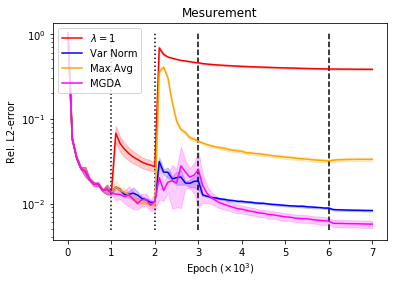

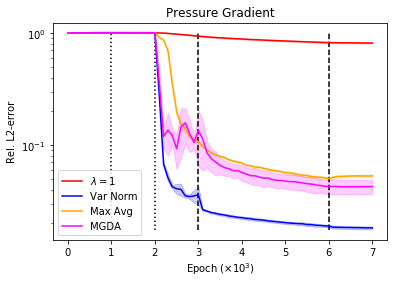

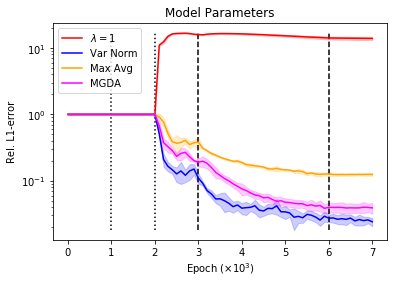

In [5]:
colors = ["red", "blue", "orange", "magenta"]
labels = [r"$\lambda=1$", "Var Norm", "Max Avg", "MGDA"]
titles = ["Mesurement", "Pressure Gradient", "Model Parameters"]
save=["fit", "pres", "param"]

for i in range(3):
    for j in range(4):
        mm = np.mean(errs,0)[j,i,:]
        ss = np.std(errs,0)[j,i,:]
        
        plt.plot(np.arange(0.0, 7.1, 0.1), mm, color=colors[j], label=labels[j])
        plt.fill_between(np.arange(0.0, 7.1, 0.1), mm-ss, mm+ss, color=colors[j], alpha=0.2)
     
    plt.vlines(1.0, np.min(errs[:,:,i,:]), np.max(errs[:,:,i,:]), linestyle="dotted")
    plt.vlines(2.0, np.min(errs[:,:,i,:]), np.max(errs[:,:,i,:]), linestyle="dotted")
    plt.vlines(3.0, np.min(errs[:,:,i,:]), np.max(errs[:,:,i,:]), linestyle="dashed")
    plt.vlines(6.0, np.min(errs[:,:,i,:]), np.max(errs[:,:,i,:]), linestyle="dashed")
    plt.yscale("log")
    plt.xlabel(r"Epoch $(\times 10^{3})$")
    plt.ylabel("Rel. L2-error" if i!=2 else "Rel. L1-error")
    plt.legend()
    plt.title(titles[i])
    plt.savefig("img_paper/errors_{}.eps".format(save[i]))
    plt.show()

# Plot Losses

In [6]:
def get_model_name(seed, method, app=""):
    model_name = ""
    if method == 3:
        model_name = "latent/model_active_s{}_l{}_n100_{}_nl{}_param_inf_dms{}_act1_meth{}_pt{}_eps{}_pseed{}_dot_grad_ms{}_train_divseq_full{}".format(seed,5,"full",0.0,256,method,1000,1e-6,1,0,app)
    else:
        model_name = "latent/model_active_s{}_l{}_n100_{}_nl{}_param_inf_dms{}_act1_meth{}_pt{}_pseed{}_dot_grad_ms{}_train_divseq_full{}".format(seed,5,"full",0.0,256,method,1000,1,0,app)
    
    return model_name

In [7]:
def mean_loss(loss, bs):
    l = loss.reshape(7000, bs)
    return np.mean(l,1)

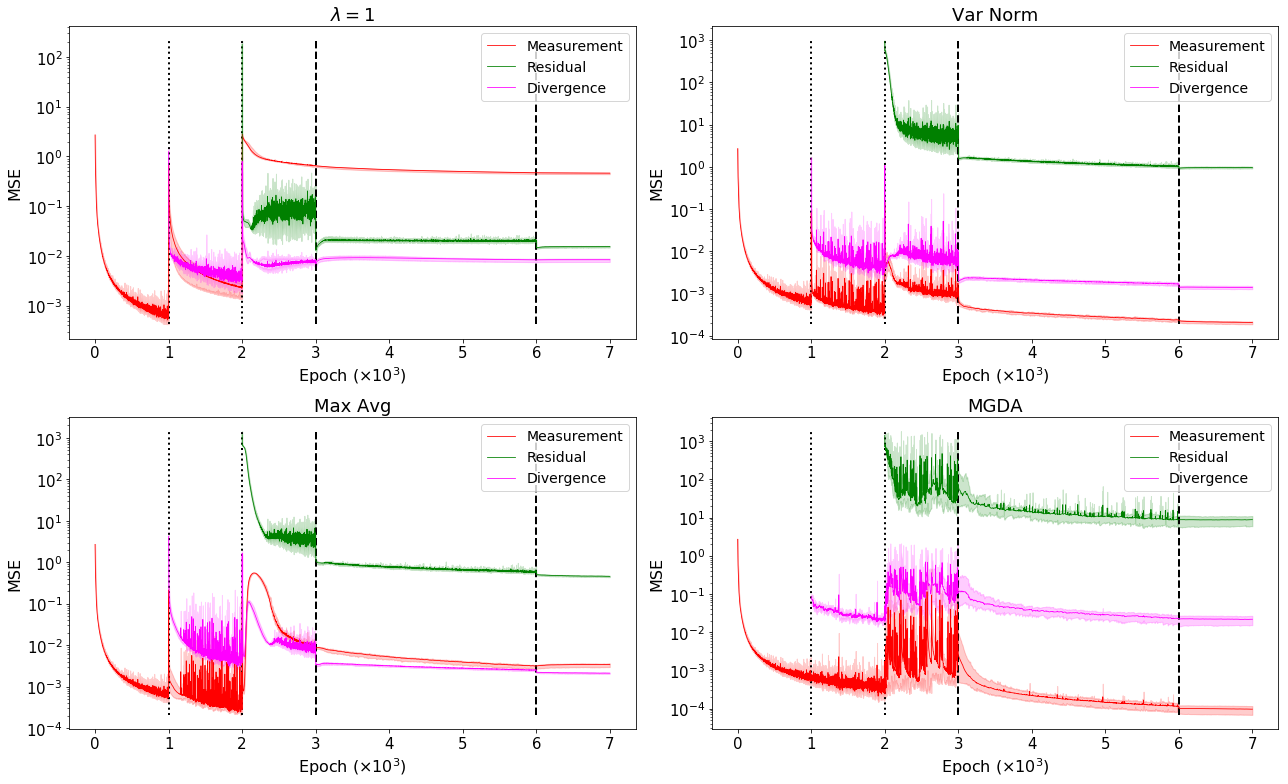

In [8]:
bs_tor = 35
skip = 1
titles = [r"$\lambda=1$", "Var Norm", "Max Avg", "MGDA"]
for i, method in enumerate([4,0,2,3]):
    loss_0 = np.zeros((5, 7000))
    loss_r = np.zeros((5, 7000))
    loss_d = np.zeros((5, 7000))
    
    for seed in range(1,6):
        model_name = get_model_name(seed,method,app="_reset_max")
        data = sio.loadmat("results/" + model_name)
    
        loss_0[seed-1,:] = mean_loss(data["lu"][0][:], bs_tor)
        loss_r[seed-1,:] = mean_loss(data["lr"][0][:], bs_tor)
        loss_d[seed-1,:] = mean_loss(data["lrd"][0][:], bs_tor)
        
    zero_idx_r = np.where(loss_r == 0.0)
    zero_idx_d = np.where(loss_d == 0.0)
    loss_r[zero_idx_r] = np.nan
    loss_d[zero_idx_d] = np.nan
    
    plt.subplot(2,2,i+1)
    plt.plot(range(0,7000,skip), np.mean(loss_0[::skip], 0), color="red", linewidth=0.8, label="Measurement")
    plt.plot(range(0,7000,skip), np.mean(loss_r[::skip], 0), color="green", linewidth=0.8, label="Residual")
    plt.plot(range(0,7000,skip), np.mean(loss_d[::skip], 0), color="magenta", linewidth=0.8, label="Divergence")
    
    plt.fill_between(range(7000), np.min(loss_0, 0), np.max(loss_0, 0), color="red", alpha=0.2)
    plt.fill_between(range(7000), np.min(loss_r, 0), np.max(loss_r, 0), color="green", alpha=0.2)
    plt.fill_between(range(7000), np.min(loss_d, 0), np.max(loss_d, 0), color="magenta", alpha=0.2)
    
    all_max = [np.max(loss_0), np.max(loss_r[:,2000:]), np.max(loss_d[:,1000:])]
    all_min = [np.min(loss_0), np.min(loss_r[:,2000:]), np.min(loss_d[:,1000:])]
    
    plt.vlines(1000, np.min(all_min), np.max(all_max), linestyle="dotted", linewidth=2)
    plt.vlines(2000, np.min(all_min), np.max(all_max), linestyle="dotted", linewidth=2)
    
    plt.vlines(3000, np.min(all_min), np.max(all_max), linestyle="dashed", linewidth=2)
    plt.vlines(6000, np.min(all_min), np.max(all_max), linestyle="dashed", linewidth=2)
    
    plt.xticks(range(0,7001,1000), range(8), fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.xlabel(r"Epoch $(\times 10^3)$", fontsize=16)
    plt.ylabel("MSE", fontsize=16)
    
    plt.yscale("log")
    plt.legend(loc="upper right", fontsize=14)
    plt.title(titles[i], fontsize=18)
    
plt.gcf().set_size_inches(18,11)
plt.tight_layout()

plt.savefig("img_paper/losses_catastrophic.eps")

# Plot Weights

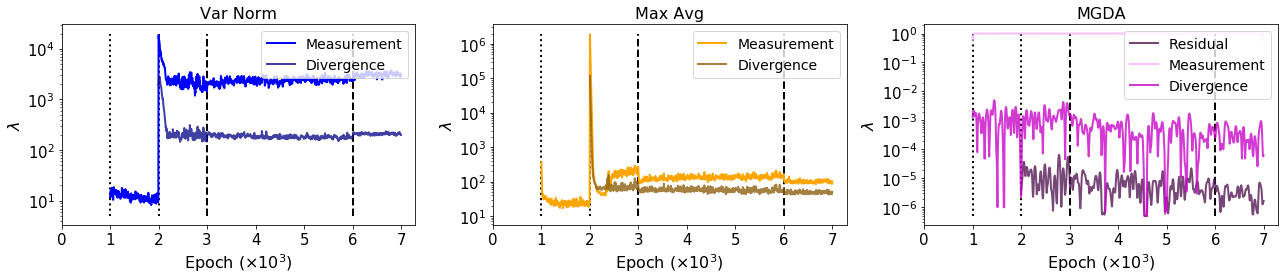

In [12]:
bs_tor = 49
skip   = 5

lims = [(5e3, 5e6), (1e2, 1e4), (1e-8, 5)]

titles = ["Var Norm", "Max Avg", "MGDA"]

d1 = sio.loadmat("results/" + get_model_name(2,0,"_reset_max"))
d2 = sio.loadmat("results/" + get_model_name(2,2,"_reset_max"))
d3 = sio.loadmat("results/" + get_model_name(2,3),"_reset_max")
d31 = sio.loadmat("results/" + get_model_name(2,3,"_reset_max"))
d4 = sio.loadmat("results/" + get_model_name(2,4),"_reset_max")

l3 = np.concatenate([d31["lambs"][:200], d3["lambs"][200:]], 0)

plt.subplot(1,3,1)

l_color_ = sns.light_palette("blue",n_colors=40)
d_color_ = sns.dark_palette("blue",n_colors=40)

plt.plot(range(1000,7000,skip), d1["lambs"][:,0], color=d_color_[39], linewidth=2, label="Measurement", alpha=1)
plt.plot(range(2000,7000,skip), d1["lambs"][200:,1], color=d_color_[19], linewidth=2, label="Divergence", alpha=.8)
plt.yscale("log")

#plt.vlines(3000, lims[i][0], lims[i][1], linestyle="dashed", linewidth=2)
#plt.vlines(6000, lims[i][0], lims[i][1], linestyle="dashed", linewidth=2)

plt.vlines(1000, 5, 2e4, linestyle="dotted", linewidth=2)
plt.vlines(2000, 5, 2e4, linestyle="dotted", linewidth=2)
plt.vlines(3000, 5, 2e4, linestyle="dashed", linewidth=2)
plt.vlines(6000, 5, 2e4, linestyle="dashed", linewidth=2)

plt.xticks(range(0,7001,1000), range(8), fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r"Epoch $(\times 10^3)$", fontsize=16)
plt.ylabel(r"$\lambda$", fontsize=16)

plt.yscale("log")
#plt.ylim(lims[i])
plt.legend(loc="upper right", fontsize=14)
plt.title("Var Norm", fontsize=16)
#plt.title(titles[i], fontsize=18)

plt.subplot(1,3,2)

l_color_ = sns.light_palette("orange",n_colors=40)
d_color_ = sns.dark_palette("orange",n_colors=40)

plt.plot(range(1000,7000,skip), d2["lambs"][:,0], color=d_color_[39], linewidth=2, label="Measurement", alpha=1)
plt.plot(range(2000,7000,skip), d2["lambs"][200:,1], color=d_color_[19], linewidth=2, label="Divergence", alpha=.8)
plt.yscale("log")

#plt.vlines(3000, lims[i][0], lims[i][1], linestyle="dashed", linewidth=2)
#plt.vlines(6000, lims[i][0], lims[i][1], linestyle="dashed", linewidth=2)

plt.vlines(1000, 1e1, 2e6, linestyle="dotted", linewidth=2)
plt.vlines(2000, 1e1, 2e6, linestyle="dotted", linewidth=2)
plt.vlines(3000, 1e1, 2e6, linestyle="dashed", linewidth=2)
plt.vlines(6000, 1e1, 2e6, linestyle="dashed", linewidth=2)

plt.xticks(range(0,7001,1000), range(8), fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r"Epoch $(\times 10^3)$", fontsize=16)
plt.ylabel(r"$\lambda$", fontsize=16)

plt.yscale("log")
#plt.ylim(lims[i])
plt.legend(loc="upper right", fontsize=14)
#plt.title(titles[i], fontsize=18)
plt.title("Max Avg", fontsize=16)

plt.subplot(1,3,3)

l_color_ = sns.light_palette("magenta",n_colors=40)
d_color_ = sns.dark_palette("magenta",n_colors=40)

win = signal.windows.hann(15)

filtered = signal.convolve(l3[200:,1], win, mode='same') / sum(win)
plt.plot(range(2000,7000,skip), filtered, color=d_color_[9], linewidth=2, label="Residual", alpha=.8)
filtered = signal.convolve(l3[:,0], win, mode='same') / sum(win)
plt.plot(range(1000,7000,skip), filtered, color=l_color_[9], linewidth=2, label="Measurement", alpha=.8)
filtered = signal.convolve(l3[:,2], win, mode='same') / sum(win)
plt.plot(range(1000,7000,skip), filtered, color=d_color_[29], linewidth=2, label="Divergence", alpha=.8) 
plt.yscale("log")

#plt.vlines(3000, lims[i][0], lims[i][1], linestyle="dashed", linewidth=2)
#plt.vlines(6000, lims[i][0], lims[i][1], linestyle="dashed", linewidth=2)

plt.vlines(1000, 5e-7, 1, linestyle="dotted", linewidth=2)
plt.vlines(2000, 5e-7, 1, linestyle="dotted", linewidth=2)
plt.vlines(3000, 5e-7, 1, linestyle="dashed", linewidth=2)
plt.vlines(6000, 5e-7, 1, linestyle="dashed", linewidth=2)

plt.xticks(range(0,7001,1000), range(8), fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r"Epoch $(\times 10^3)$", fontsize=16)
plt.ylabel(r"$\lambda$", fontsize=16)

plt.yscale("log")
#plt.ylim(lims[i])
plt.legend(loc="upper right", fontsize=14)
#plt.title(titles[i], fontsize=18)
plt.title("MGDA", fontsize=16)
    
plt.gcf().set_size_inches(18,4)
plt.tight_layout()

plt.savefig("img_paper/lambs_catastrophic.eps")
plt.show()

# Plot Slices

In [13]:
data = sio.loadmat("/projects/ppm/surya/spectral_simulations/meso_bacterial_turbulence_IFRK4_N{}_2pi_dt0p01_Tmax10.mat".format(256))
u = np.transpose(data["store_data_u"], (2,0,1))[420:470,:,:]
v = np.transpose(data["store_data_v"], (2,0,1))[420:470,:,:]
w = np.transpose(data["store_data"], (2,0,1))[420:470:,:]

cut_lb=64
cut_ub=128

def pressure_eval(t_):
    u = np.transpose(data["store_data_u"], (2,0,1))[420+t_,:,:]
    v = np.transpose(data["store_data_v"], (2,0,1))[420+t_,:,:]
    w = np.transpose(data["store_data"], (2,0,1))[420+t_,:,:]
    
    N = 256; domain_size = 2.0*np.pi; h = (domain_size)/N;
    x = [h*i for i in range(1,N+1)]; y = [h*i for i in range(1,N+1)]
    dx = x[1] - x[0]; dy = y[1] - y[0];

    xx = np.zeros((N,N), dtype=float); yy=np.zeros((N,N), dtype=float)
    for i in range(N):
        for j in range(N):
            xx[i,j] = x[i]
            yy[i,j] = y[j]  

    S = -2.5; alpha = -1; beta = 0.5; lambda_0 = 1.0 - S; 
    
    lambda_1 = 0; eps = 0.1*10**(-13);

    k_x = k_y = (2.0*np.pi/domain_size)*1j*np.fft.fftfreq (N , 1./ N). astype ( int );
    kx    = np.zeros((N,N), dtype=complex);  
    ky    = np.zeros((N,N), dtype=complex);
    kxx   = np.zeros((N,N), dtype=complex); 
    kyy   = np.zeros((N,N), dtype=complex);
    kxxxx = np.zeros((N,N), dtype=complex);
    kyyyy = np.zeros((N,N), dtype=complex);

    for i in range(N):
        for j in range(N):
            kx[i,j]    = k_x[i]; ky[i,j]    = k_y[j];
            kxx[i,j]   = k_x[i]**2; kyy[i,j]   = k_y[j]**2;
            kxxxx[i,j] = k_x[i]**4; kyyyy[i,j] = k_y[j]**4;

    lap  = kxx + kyy + eps;
    inv_lap    = 1./lap;  

    uhat = np.fft.fft2(u); vhat = np.fft.fft2(v);
    ux = np.real(np.fft.ifft2(kx*uhat)); uy = np.real(np.fft.ifft2(ky*uhat))
    vx = np.real(np.fft.ifft2(kx*vhat)); vy = np.real(np.fft.ifft2(ky*vhat))
    adv_uhat = np.fft.fft2(u*ux + v*uy); adv_vhat = np.fft.fft2(u*vx + v*vy); 
    mod      = (u*u + v*v); mod_hat = np.fft.fft2(mod); mod_hat = mod_hat;
    mod_u    = mod*u; mod_v = mod*v; mod_uhat = np.fft.fft2(mod_u); mod_vhat = np.fft.fft2(mod_v);
    phat     = ( -lambda_0*(kx*adv_uhat + ky*adv_vhat) + lambda_1*lap*mod_hat \
                 -beta*(kx*mod_uhat + ky*mod_vhat) )*inv_lap;   

    pxhat = kx*phat; pyhat = ky*phat;
    
    return np.real(np.fft.ifft2(phat)), np.real(np.fft.ifft2(pxhat)), np.real(np.fft.ifft2(pyhat))

# compute centered pressure
def p_norm(d):
    return (d - np.mean(d, (1,2), keepdims=True)).reshape(-1)

# get GT pressure
p  = np.zeros((50,64,64))
px = np.zeros((50,64,64))
py = np.zeros((50,64,64))
for i in range(0, 50):
    _p,_px,_py = pressure_eval(i)
    
    p[i,:,:]  = _p[cut_lb:cut_ub, cut_lb:cut_ub]
    px[i,:,:] = _px[cut_lb:cut_ub, cut_lb:cut_ub]
    py[i,:,:] = _py[cut_lb:cut_ub, cut_lb:cut_ub]
    
data = sio.loadmat("/projects/ppm/surya/spectral_simulations/meso_bacterial_turbulence_IFRK4_N{}_2pi_dt0p01_Tmax10.mat".format(256))
u = np.transpose(data["store_data_u"], (2,0,1))[420:470,cut_lb:cut_ub, cut_lb:cut_ub]
v = np.transpose(data["store_data_v"], (2,0,1))[420:470,cut_lb:cut_ub, cut_lb:cut_ub]
w = np.transpose(data["store_data"], (2,0,1))[420:470:,cut_lb:cut_ub, cut_lb:cut_ub]

N = 256; domain_size = 2.0*np.pi; h = (domain_size)/N;
x = [h*i for i in range(1,N+1)]; y = [h*i for i in range(1,N+1)]
dx = x[1] - x[0]; dy = y[1] - y[0];

x = x[cut_lb:cut_ub]
y = y[cut_lb:cut_ub]

evals/latent/eval_s2_nl0.0_dms256_meth4_pt1000_pseed1_dot_grad_ms0_train_divseq_full
evals/latent/eval_s2_nl0.0_dms256_meth0_pt1000_pseed1_dot_grad_ms0_train_divseq_full
evals/latent/eval_s2_nl0.0_dms256_meth2_pt1000_pseed1_dot_grad_ms0_train_divseq_full_reset_max
evals/latent/eval_s2_nl0.0_dms256_meth3_pt1000_eps1e-06_pseed1_dot_grad_ms0_train_divseq_full


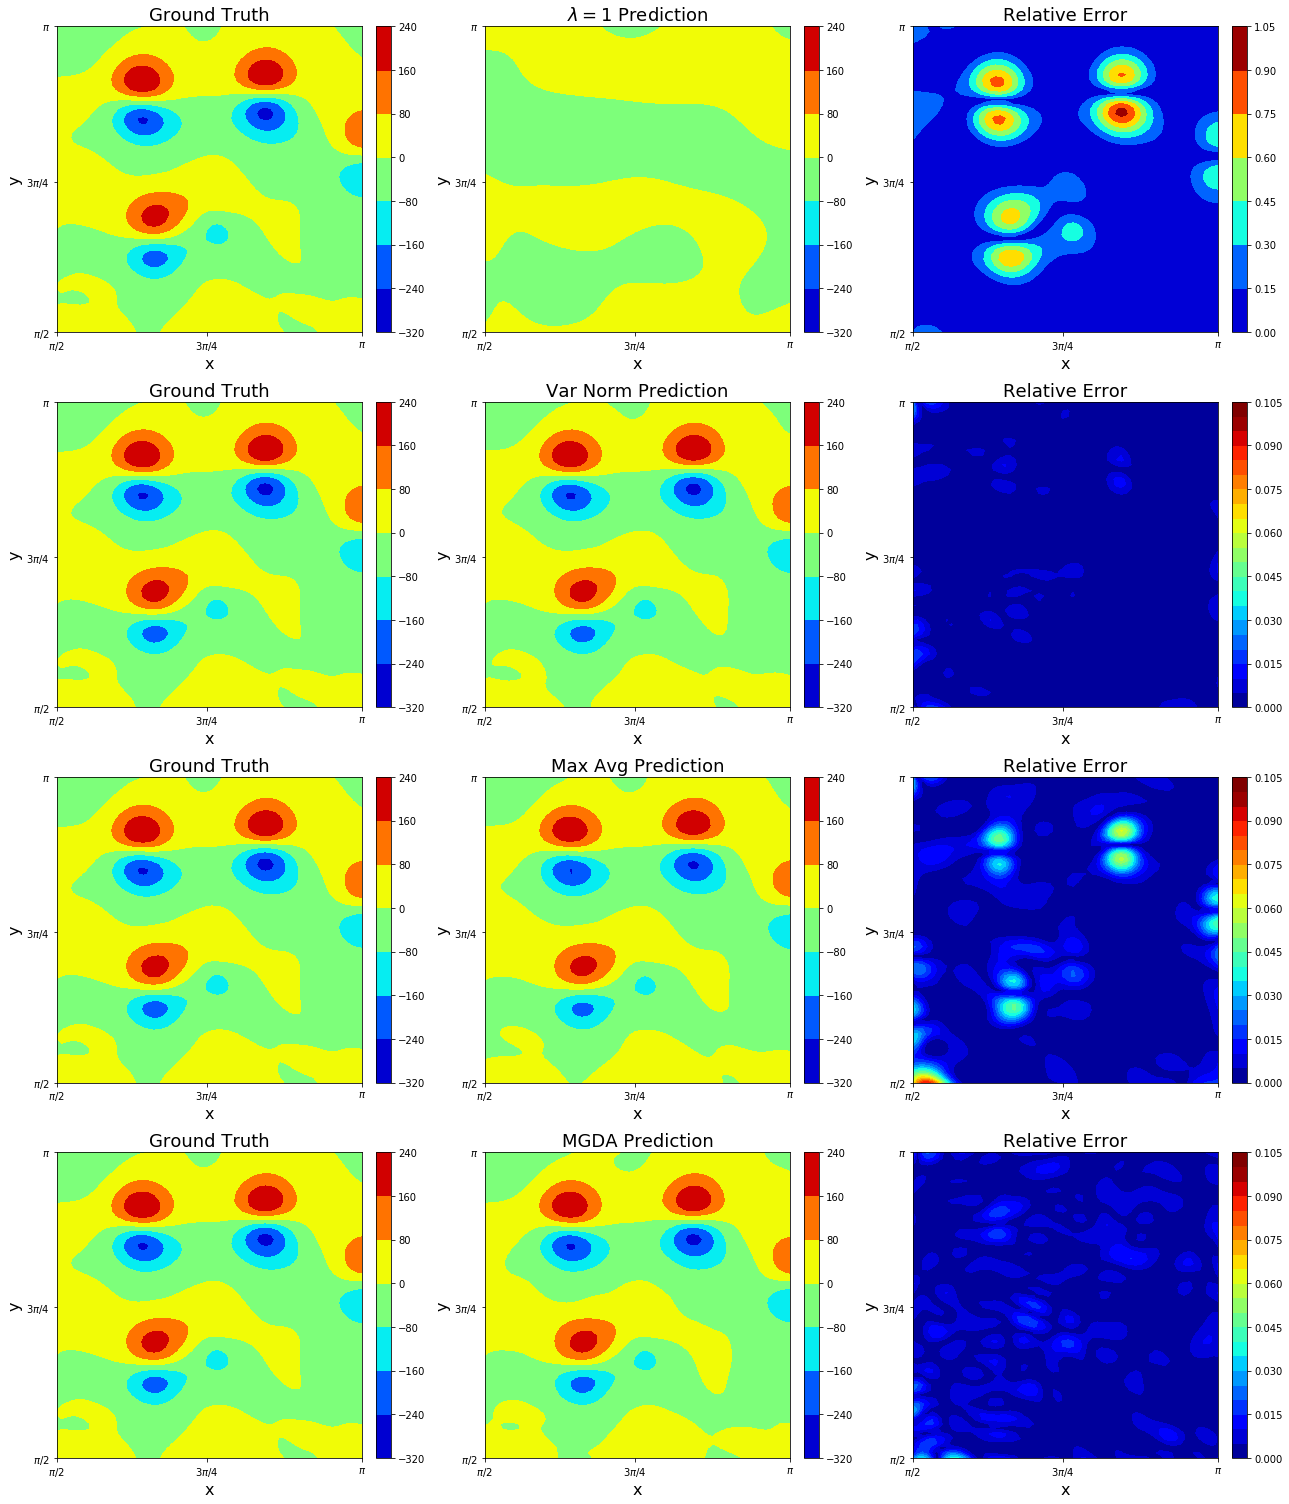

In [17]:
label = [r"$\lambda=1$", "Var Norm", "Max Avg", "MGDA"]

seed = 2
t_ = 45
fig, axs = plt.subplots(4,3,figsize=(18,21))
for k,i in enumerate([4,0,2,3]):
    d = None
    save_name = ""
    if i == 3:
        save_name = "evals/latent/eval_s{}_nl{}_dms{}_meth{}_pt{}_eps{}_pseed{}_dot_grad_ms{}_train_divseq_full_reset_max".format(seed,0.0,256,i,1000,1e-6,1,0)
    else:
        save_name = "evals/latent/eval_s{}_nl{}_dms{}_meth{}_pt{}_pseed{}_dot_grad_ms{}_train_divseq_full_reset_max".format(seed,0.0,256,i,1000,1,0)
    print(save_name)
    d = sio.loadmat(save_name)
        
    im1 = axs[k,0].contourf(x,y,px[t_,:,:], levels=[-320,-240,-160,-80,0,80,160,240], cmap="jet", vmin=-320, vmax=240)
    im2 = axs[k,1].contourf(x,y,d["px_full"][t_,:,:], levels=[-320,-240,-160,-80,0,80,160,240], cmap="jet", vmin=-320, vmax=240)
    
    if i == 4:
        im3 = axs[k,2].contourf(x,y,np.abs(d["px_full"][t_,:,:]-px[t_,:,:])/np.max(np.abs(px[t_,:,:])), cmap="jet", vmin=0.0, vmax=1)
    else:
        levels=np.arange(0.0,0.11,0.005)
        im3 = axs[k,2].contourf(x,y,np.abs(d["px_full"][t_,:,:]-px[t_,:,:])/np.max(np.abs(px[t_,:,:])), levels=levels, cmap="jet", vmin=0.0, vmax=0.1)
    
    fig.colorbar(im1, ax=axs[k,0], fraction=0.05, pad=0.04)
    fig.colorbar(im2, ax=axs[k,1], fraction=0.05, pad=0.04)
    fig.colorbar(im3, ax=axs[k,2], fraction=0.05, pad=0.04)
    
    for j in range(3):
        axs[k, j].set_xticks([x[0],x[31],x[-1]])
        axs[k, j].set_xticklabels([r"$\pi/2$", r"$3\pi/4$", r"$\pi$"])
        axs[k, j].set_yticks([x[0],x[31],x[-1]])
        axs[k, j].set_yticklabels([r"$\pi/2$", r"$3\pi/4$", r"$\pi$"])
        axs[k, j].set_ylabel("y", fontsize=16)
        axs[k, j].set_xlabel("x", fontsize=16)
    
    axs[k,0].set_title("Ground Truth", fontsize=18)
    axs[k,1].set_title(label[k] + " Prediction", fontsize=18)
    axs[k,2].set_title("Relative Error", fontsize=18)
        
plt.tight_layout()
plt.savefig("img_paper/pressure_snapshot_nl0.0.eps")